In [ ]:
import zipfile
!unzip /content/drive/MyDrive/MANN/One-shot-Memory-Augmented-NN.zip

Archive:  /content/drive/MyDrive/MANN/One-shot-Memory-Augmented-NN.zip
replace One-shot-Memory-Augmented-NN/.git/config? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import zipfile
!unzip /content/drive/MyDrive/MANN/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/images_evaluation/Mongolian/character28/1386_05.png  
  inflating: data/images_evaluation/Mongolian/character28/1386_06.png  
  inflating: data/images_evaluation/Mongolian/character28/1386_07.png  
  inflating: data/images_evaluation/Mongolian/character28/1386_08.png  
  inflating: data/images_evaluation/Mongolian/character28/1386_09.png  
  inflating: data/images_evaluation/Mongolian/character28/1386_10.png  
  inflating: data/images_evaluation/Mongolian/character28/1386_11.png  
  inflating: data/images_evaluation/Mongolian/character28/1386_12.png  
  inflating: data/images_evaluation/Mongolian/character28/1386_13.png  
  inflating: data/images_evaluation/Mongolian/character28/1386_14.png  
  inflating: data/images_evaluation/Mongolian/character28/1386_15.png  
  inflating: data/images_evaluation/Mongolian/character28/1386_16.png  
  inflating: data/images_evaluation/Mongolian/character28/1386_17.png  
  inflating: 

In [1]:
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install scikit-image

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utilys as ut
import os
from matplotlib.pyplot import imread
from skimage.transform import resize
#from scipy.misc import imread,imresize

In [ ]:
width = 20

# gather data paths
subfolds = ut.extend_children('data','')
datafolds = [subfolds[1]]
alphabets = ut.extend_generation(datafolds,'')
charpaths = ut.extend_generation(alphabets,'')
chars_dataset = [v.split('/')[2]+'/'+v.split('/')[3] for v in charpaths]
#print(chars_dataset)
# index-value conversion dictionaries for character set
i2v = {i:v for i, v in enumerate(chars_dataset)}
v2i = {v:i for i, v in enumerate(chars_dataset)}

# get size of dataset
mc_dataset = len(charpaths)
print(mc_dataset,'total character classes')

# train split
mc_train = 764
chars_train = chars_dataset[:mc_train]
classes_train = [v2i[v] for v in chars_train]

# validation split
mc_val = mc_dataset-mc_train
chars_val = chars_dataset[-mc_val:]
classes_val = [v2i[v] for v in chars_val]

print('%s characters assigned for training, %s characters assigned for validation'%(mc_train,mc_val))

964 total character classes
764 characters assigned for training, 200 characters assigned for validation


In [ ]:
# load images from character paths
imgs_dataset = []
for i, charfold in enumerate(charpaths):
    if i%200==0:
        #print(charfold)
        print('%s/%s character folders loaded'%(i,mc_dataset))
    imgs_dataset.append([ ut.load_image(imgpath,(width,width))/127.5-1 for imgpath in ut.extend_children(charfold,'.png') ] )
    # access imgs_dataset [ character index ] [ sample index ] [ row,col ]

# split images between train and validation sets
imgs_train = imgs_dataset[:mc_train]
imgs_val = imgs_dataset[-mc_val:]

0/964 character folders loaded
200/964 character folders loaded
400/964 character folders loaded
600/964 character folders loaded
800/964 character folders loaded


In [ ]:
#classes_val, imgs_val = ut.shuffle_xy(classes_val,imgs_val,7)

n_classes = 5
memory_size = 128 # number of features per entry
memory_dim = 40 # number of entries in memory
learning_rate = 1e-3
batch_size = 16

n_inputs = width*width+n_classes
n_hnodes = 200
n_outputs = n_classes
mem_size = memory_size
mem_dim = memory_dim


weights = lambda shape,name: tf.Variable(tf.truncated_normal(shape, stddev=0.1),name=name)
biases = lambda shape,name: tf.Variable(tf.constant(0.1, shape=shape),name=name)
conv2d = lambda x, W: tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding='SAME')
max_pool = lambda x: tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [ ]:
import tensorflow as tf
from MANN import MANN

tf.compat.v1.disable_eager_execution()

X = tf.compat.v1.placeholder(tf.float32, shape=[batch_size, None, width, width])
y = tf.compat.v1.placeholder(tf.float32, shape=[batch_size, None, n_classes])

X_mat = tf.transpose(tf.reshape(X,[batch_size,-1,width*width]),perm=[1,0,2])
y_tr = tf.transpose(y,perm=[1,0,2])
y_tm1 = tf.concat([tf.zeros([1,batch_size,n_classes]),y_tr[:-1,:]],0)

if False:
    W_c1 = weights([5,5,1,2],'Conv1_Weights')
    b_c1 = biases([2],'Conv1_Biases')
    W_c2 = weights([5,5,2,4],'Conv2_Weights')
    b_c2 = biases([4],'Conv2_Biases')

    # 100x100x1
    h_c1 = tf.nn.relu(conv2d(x_image,W_c1)+b_c1)
    # 50x50x2
    h_p1 = max_pool(h_c1)
    # 25x25x2
    h_c2 = tf.nn.relu(conv2d(h_p1,W_c2)+b_c2)
    # 13x13x4
    h_p2 = max_pool(h_c2)
    # 7x7x4
    h_conv = tf.reshape(h_p2,[-1,7*7*4])
    # 196

X_mann = tf.concat([X_mat,y_tm1],-1)

MANN1 = MANN(n_inputs,n_hnodes,n_classes,memory_size,memory_dim,X_mann,batch_size)

In [ ]:
n_xh = n_inputs+n_hnodes
n_hr = n_hnodes+mem_dim
W_init = tf.compat.v1.keras.initializers.VarianceScaling()
b_init = tf.constant_initializer(0)
#with tf.variable_scope('Weights', reuse=True):
if False:
    # LSTM Gate Weights
    W_gf = tf.get_variable('W_forget_gate', shape=[n_xh,n_hnodes], initializer=W_init)
    b_gf = tf.get_variable('b_forget_gate', shape=[n_hnodes], initializer=b_init)
    W_gi = tf.get_variable('W_input_gate', shape=[n_xh,n_hnodes], initializer=W_init)
    b_gi = tf.get_variable('b_input_gate', shape=[n_hnodes], initializer=b_init)
    W_go = tf.get_variable('W_output_gate', shape=[n_xh,n_hnodes], initializer=W_init)
    b_go = tf.get_variable('b_output_gate', shape=[n_hnodes], initializer=b_init)
    # LSTM Tanh Weights
    W_u = tf.get_variable('W_remember', shape=[n_xh,n_hnodes], initializer=W_init)
    b_u = tf.get_variable('b_remember', shape=[n_hnodes], initializer=b_init)
    # Controller Weights
    W_kr = tf.get_variable('W_read_key', shape=[n_hnodes,mem_dim], initializer=W_init)
    b_kr = tf.get_variable('b_read_key', shape=[mem_dim], initializer=b_init)
    W_kw = tf.get_variable('W_write_key', shape=[n_hnodes,mem_dim], initializer=W_init)
    b_kw = tf.get_variable('b_write_key', shape=[mem_dim], initializer=b_init)
    alpha = tf.get_variable('sigmoid_alpha', shape=[1,1], initializer=b_init)
    # Logit Weights
    W_o = tf.get_variable('W_output', shape=[n_hr,n_outputs], initializer=W_init)
    b_o = tf.get_variable('b_output', shape=[n_outputs], initializer=b_init)
    pass
#thetas = [W_gf,b_gf,W_gi,b_gi,W_go,b_go,W_u,b_u,W_kr,b_kr,W_kw,alpha,b_kw,W_o,b_o]

In [ ]:
M, h, c, wu, wr, r, o = MANN1

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_tr,logits=o)
loss = tf.reduce_mean(xentropy)

trainable_variables = tf.compat.v1.trainable_variables()
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
grads, _ = tf.clip_by_global_norm(tf.gradients(loss,trainable_variables),30)
train_step = optimizer.apply_gradients(zip(grads,trainable_variables))

correct_prediction = tf.equal(tf.argmax(o, -1), tf.argmax(y_tr, -1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())
saver = tf.compat.v1.train.Saver()
savedir = './saved_models_omniglot/Mod1/'

In [ ]:
import time
import os

n_epochs = 400
loss_plot, accuracy_plot = [], []
loss_plot2, accuracy_plot2 = [], []
if True:
    saver.restore(sess, os.path.join(savedir,'400/Model.ckpt'))

with sess.as_default():
    for epoch in range(n_epochs):
        print('Epoch {} starting..'.format(epoch+1))
        epoch_start = time.time()
        classes_epoch, imgs_epoch = ut.shuffle_xy(classes_train,imgs_train)
        lo = 10000
        ac = 0
        n_batches = len(classes_epoch)//(n_classes*batch_size)
        for batch in range(n_batches):
            classes_batch = classes_epoch[batch*n_classes*batch_size:(batch+1)*n_classes*batch_size]
            imgs_batch = imgs_epoch[batch*n_classes*batch_size:(batch+1)*n_classes*batch_size]
            
            Xl_batch, yl_batch = [], []
            for episode in range(batch_size):
                imgs_ep = imgs_batch[episode*n_classes:(episode+1)*n_classes]
                Xl_ep, yl_ep = [], []
                for ind, cat in enumerate(imgs_ep):
                    for arr in cat:
                        Xl_ep.append(arr)
                        yl_ep.append(ut.one_hot(ind,n_classes))
                Xl_shuff, yl_shuff = ut.shuffle_xy(Xl_ep,yl_ep)
                X_arr, y_arr = np.asarray(Xl_shuff), np.asarray(yl_shuff)
                Xl_batch.append(X_arr)
                yl_batch.append(y_arr)
            X_train, y_train = np.asarray(Xl_batch), np.asarray(yl_batch)

            _, loss_train, accuracy_train = sess.run((train_step,loss,accuracy),feed_dict={X:X_train,y:y_train})
            if lo>loss_train:
              lo = loss_train
            if ac<accuracy_train:
              ac = accuracy_train
            print('Epoch %d'%(epoch+1),'/ Batch (%d/%d)'%(batch+1,n_batches),'/ Accuracy %.4f / Loss %f'%(accuracy_train,loss_train))
        loss_plot.append(loss_train)
        accuracy_plot.append(accuracy_train)
        loss_plot2.append(lo)
        accuracy_plot2.append(ac)
            
        epoch_end = time.time()
        time_elapsed = epoch_end-epoch_start
        print('Epoch {} complete,'.format(epoch+1),time_elapsed,'seconds elapsed')
        if (epoch+1)%50 == 0:
            iterdir = os.path.join(savedir,str(epoch+1))
            if not os.path.exists(iterdir):
                os.makedirs(iterdir)
            saver.save(sess,'{}/Model.ckpt'.format(iterdir))
        print()

INFO:tensorflow:Restoring parameters from ./saved_models_omniglot/Mod1/400/Model.ckpt
Epoch 1 starting..
Epoch 1 / Batch (1/9) / Accuracy 0.2750 / Loss 1.556647
Epoch 1 / Batch (2/9) / Accuracy 0.2606 / Loss 1.561239
Epoch 1 / Batch (3/9) / Accuracy 0.2681 / Loss 1.562886
Epoch 1 / Batch (4/9) / Accuracy 0.2738 / Loss 1.556728
Epoch 1 / Batch (5/9) / Accuracy 0.2800 / Loss 1.555311
Epoch 1 / Batch (6/9) / Accuracy 0.2794 / Loss 1.559687
Epoch 1 / Batch (7/9) / Accuracy 0.2775 / Loss 1.551844
Epoch 1 / Batch (8/9) / Accuracy 0.2788 / Loss 1.555108
Epoch 1 / Batch (9/9) / Accuracy 0.2706 / Loss 1.553957
Epoch 1 complete, 2.5610480308532715 seconds elapsed

Epoch 2 starting..
Epoch 2 / Batch (1/9) / Accuracy 0.2806 / Loss 1.551204
Epoch 2 / Batch (2/9) / Accuracy 0.2719 / Loss 1.550385
Epoch 2 / Batch (3/9) / Accuracy 0.2713 / Loss 1.552791
Epoch 2 / Batch (4/9) / Accuracy 0.2612 / Loss 1.568821
Epoch 2 / Batch (5/9) / Accuracy 0.2631 / Loss 1.564814
Epoch 2 / Batch (6/9) / Accuracy 0.264

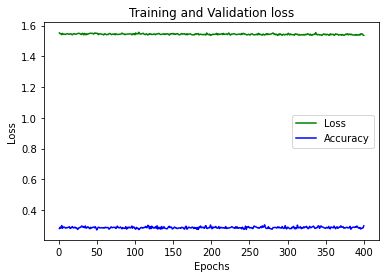

In [ ]:
epochs = range(1,401)
plt.plot(epochs, loss_plot2, 'g', label='Loss')
plt.plot(epochs, accuracy_plot2, 'b', label='Accuracy')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import csv

a = np.asarray([loss_plot,accuracy_plot,loss_plot2, accuracy_plot2 ])
with open('7th.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(a)

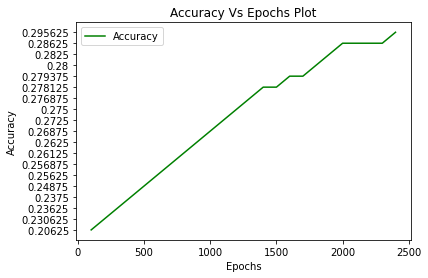

In [ ]:
x = []
y = []
#z = []
  
with open('DATA_main.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in lines:
        x.append(row[0])
        y.append(float(row[1]))
  
plt.plot(y,x, 'g', label='Accuracy')
#plt.plot(epochs, accuracy_plot2, 'b', label='Accuracy')
plt.title('Accuracy Vs Epochs Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


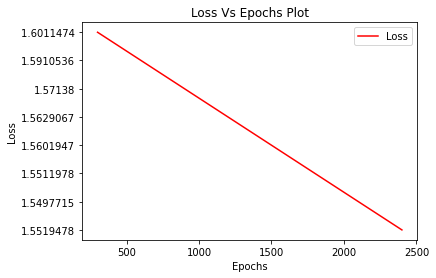

In [11]:
import csv
import matplotlib.pyplot as plt
los = []
epo = []
#z = []
  
with open('DATA_loss.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    for row in lines:
        los.append(row[0])
        epo.append(float(row[1]))
  
#los, epo = zip(*sorted(zip(los, epo)))
#print(los)
plt.plot(epo,los, 'r', label='Loss')
plt.gca().invert_yaxis()
#plt.plot(epochs, accuracy_plot2, 'b', label='Loss')
plt.title('Loss Vs Epochs Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()